In [1]:
import re
from glob import iglob, glob
import matplotlib.pyplot as plt
from astropy.io import ascii
from lightkurve import MPLSTYLE
from lightkurve import open as open_lc
from lightkurve.utils import running_mean as RunningMean
import numpy as np
from scipy.stats import median_absolute_deviation

In [2]:
# Regular expression filename decoder
reg = re.compile(r'(\d{8,9})([OPT][RCH])')

def decode_filename(filepath):
    """
    Function to decode LightCurveFITS filenames:
    {TICID}{Type}.fits
    
    Types: Threshold (TH), Pipeline (OR), Percentile (PER)
    
    :param filepath: filepath to FITS file
    :return: ticid, aperture type
    """
    ticid, code = reg.search(filepath).groups()
    if code.upper() == 'TH':
        ap_type = 'Threshold'
    elif code.upper() == 'OR':
        ap_type = 'Pipeline'
    else:
        ap_type = 'Percentile'
    return ticid, ap_type


def RunningMedian(x,N):
    """
    Function to calculate the running median of a 1-D dataset x
    using a window size N
    """
    idx = np.arange(N) + np.arange(len(x)-N+1)[:, None]
    b = [row[row>0] for row in x[idx]]
    return np.array([*map(np.median, b)])


In [3]:
# Import target list
targets = ascii.read('DataInput/cluster_targets_tic.ecsv')

# Get filepaths to LightCurve FITS
src_lcfs = 'LightCurvesFITS/*.fits'
fits_paths = glob(src_lcfs)

# Define Program parameters
outlier_sigma = 3.0
running_mean_window = 3/4  # in days

In [5]:
# Get sample light curve
fits_path = fits_paths[7]

# Import sample FITS Light Curve, remove outliers, and long term trends
ticid, ap_type = decode_filename(fits_path)
lcf = open_lc(fits_path)
lc = lcf.get_lightcurve('FLUX')
cleaned = lc.remove_outliers(sigma=outlier_sigma).flatten(501)

# Amplitude determination; max - min
flux_min, flux_max = np.percentile(cleaned.flux, [1, 99])
amplitude = (flux_max - flux_min) / 2

# Window size is calculated from number of days; convert to cadence (30-min) units
window_size = round(running_mean_window * 24.0 * 2)

# Get all windows indices; shape (LC.size, window.size)
idx = np.arange(window_size) + np.arange(cleaned.flux.size-window_size+1)[:, None]

# Calculate running mean, and running std
run_mean = RunningMean(data=cleaned.flux, window_size=window_size)
deviation_windows1 = run_mean[:, None] - cleaned.flux[idx]
run_std = np.std(deviation_windows1, axis=1, ddof=1)
avg_std = run_std.mean()
median_std = np.median(run_std)

# Calculate running median, and running MAD
run_median = RunningMedian(cleaned.flux, window_size)
deviation_windows2 = run_median[:, None] - cleaned.flux[idx]
run_mad = median_absolute_deviation(deviation_windows2, axis=1)
avg_mad = run_mad.mean()
med_mad = np.median(run_mad)

print(f'\tWindow size = {window_size} cadences\n')

print(f'Amplitude metric = {amplitude:.3f}\n')

print('Four noise metrics:\n')

print(f'average running std = {avg_std*1e6:.2f} ppm')
print(f'median running std = {median_std*1e6:.2f} ppm\n')
print(f'average running MAD = {avg_mad*1e6:.2f} ppm')
print(f'median running MAD = {med_mad*1e6:.2f} ppm')

	Window size = 36 cadences

Amplitude metric = 0.017

Four noise metrics:

average running std = 2518.83 ppm
median running std = 2227.71 ppm

average running MAD = 2650.10 ppm
median running MAD = 2323.75 ppm


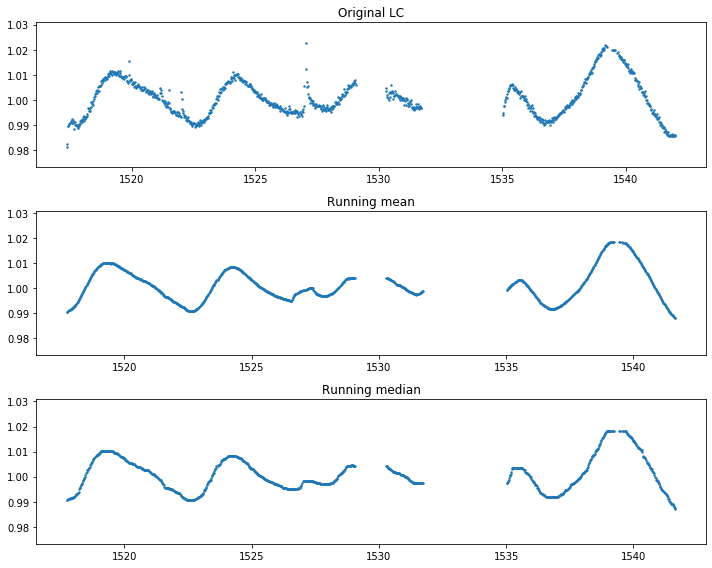

In [6]:
# Time array for running mean/median 
time = cleaned.time[window_size//2: -window_size//2+1]

# Plot the original LC, its running median and median
fig, [ax, ax1, ax2] = plt.subplots(3, 1, figsize=(10, 8), sharey=True)
ax.set_title('Original LC')
ax1.set_title('Running mean')
ax2.set_title('Running median')

ax.scatter(cleaned.time, cleaned.flux, s=2)
ax1.scatter(time, run_mean, s=2)
ax2.scatter(time, run_median, s=2)

plt.tight_layout()
plt.show()

The running STD and MAD are performed on the residuals/deviations of the original light curve from the running mean/median

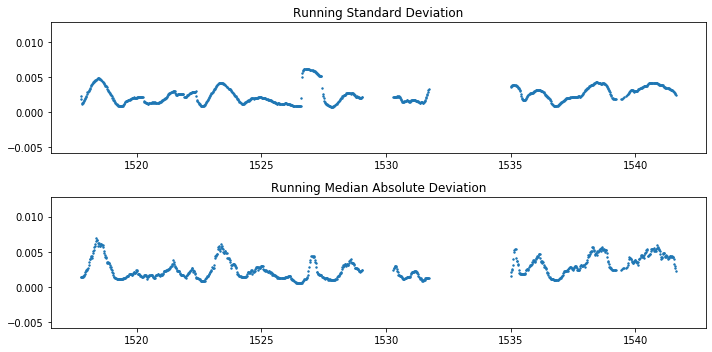

In [9]:
# Plot the running standard deviation, and MAD

fig, [ax3, ax4] = plt.subplots(2, 1, figsize=(10, 5), sharey=True)
ax3.set_title('Running Standard Deviation')
ax4.set_title('Running Median Absolute Deviation')

ax3.scatter(time, run_std, s=2)
ax4.scatter(time, run_mad, s=2)

plt.tight_layout()
plt.show()